# First Floor Height Feature Selection

Exploring the NYC Building Elevation and Subgrade (BES) Data Set in Python  

Author: Mark Bauer

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import duckdb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
# Printing verions of Python modules and packages with **watermark** - the IPython magic extension.
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

pandas    : 1.4.3
matplotlib: 3.5.2
seaborn   : 0.11.2



# Data Set: Building Elevation and Subgrade (BES)

In [3]:
# create a DuckDB database instance
con = duckdb.connect()

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM read_parquet('data/bes-data.parquet')").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     861876 │
└────────────┘



In [4]:
bes_df = con.sql("SELECT * FROM read_parquet('data/bes-data.parquet')").df()

rows, cols = bes_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
bes_df.head()

rows: 861,876
columns: 26


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


`z_grade`: The elevation of the building at it's lowest adjacent grade - the lowest point where the building touches the ground.

`z_floor`: The elevation of what is estimated to be the lowest actively used floor.

Definitions from the data dictionary.

In [5]:
bes_df = (
    bes_df
    .loc[
        (bes_df['z_floor'] != 0)
        & (bes_df['z_grade'] != 0)
        & (bes_df['notes1'] == 'Property was Successfully Measured')]
    .reset_index(drop=True)
)

print('new shape of data:', bes_df.shape)
bes_df.head()

new shape of data: (646781, 26)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


Calculating Height from Building Adjacent Grade to First Floor.

In [6]:
# height from building floor to grade
bes_df['z_floor_grade'] = bes_df['z_floor'] - bes_df['z_grade']

# summary stats
bes_df['z_floor_grade'].describe()

count    646781.000000
mean          3.834224
std           2.880029
min          -8.832000
25%           1.671000
50%           3.365000
75%           5.009000
max          83.759000
Name: z_floor_grade, dtype: float64

# Data Set: NYC Building Footprints

In [7]:
path = "https://data.cityofnewyork.us/api/views/qb5r-6dgf/rows.csv?accessType=DOWNLOAD"
buildings_df = pd.read_csv(path, low_memory=False)

rows, cols = buildings_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
buildings_df.head()

rows: 1,083,102
columns: 16


,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID
0,MULTIPOLYGON (((-73.96664570466969 40.62599676...,NaN,3170958,1925.0,08/22/2017 12:00:00 AM,Constructed,96807,29.749853,2100,40.0,0,0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F}
1,MULTIPOLYGON (((-74.16790202462265 40.63936048...,NaN,5028452,1965.0,08/22/2017 12:00:00 AM,Constructed,326368,22.630000,2100,39.0,0,0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520}
2,MULTIPOLYGON (((-74.19510813278613 40.55610681...,NaN,5078368,1970.0,08/22/2017 12:00:00 AM,Constructed,746627,35.760000,2100,51.0,0,0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068}
3,MULTIPOLYGON (((-73.96113466505085 40.57743931...,NaN,3245111,1928.0,08/22/2017 12:00:00 AM,Constructed,786626,37.500000,2100,6.0,0,0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF}
4,MULTIPOLYGON (((-73.75421559146166 40.75591276...,NaN,4161096,1950.0,08/22/2017 12:00:00 AM,Constructed,746409,18.015113,2100,93.0,0,0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D}


In [8]:
buildings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083102 entries, 0 to 1083101
Data columns (total 16 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   the_geom    1083102 non-null  object 
 1   NAME        2254 non-null     object 
 2   BIN         1083102 non-null  int64  
 3   CNSTRCT_YR  1072833 non-null  float64
 4   LSTMODDATE  1083102 non-null  object 
 5   LSTSTATYPE  1082774 non-null  object 
 6   DOITT_ID    1083102 non-null  int64  
 7   HEIGHTROOF  1080523 non-null  float64
 8   FEAT_CODE   1083102 non-null  int64  
 9   GROUNDELEV  1082550 non-null  float64
 10  SHAPE_AREA  1083102 non-null  int64  
 11  SHAPE_LEN   1083102 non-null  int64  
 12  BASE_BBL    1083102 non-null  int64  
 13  MPLUTO_BBL  1083102 non-null  int64  
 14  GEOMSOURCE  1082806 non-null  object 
 15  GLOBALID    1083102 non-null  object 
dtypes: float64(3), int64(7), object(6)
memory usage: 132.2+ MB


# Data Set: NYC PLUTO

In [9]:
path = "https://data.cityofnewyork.us/api/views/64uk-42ks/rows.csv?accessType=DOWNLOAD"
pluto_df = pd.read_csv(path, low_memory=False)

rows, cols = pluto_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
pluto_df.head()

rows: 858,572
columns: 101


,borough,block,lot,community board,census tract 2010,cb2010,schooldist,council district,postcode,firecomp,...,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020
0,QN,798,31,401.0,123.01,2006.0,30.0,22.0,11105.0,E263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4012301.0,4.012301e+10
1,BK,6429,16,311.0,172.00,2004.0,20.0,50.0,11228.0,L149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3017200.0,3.017200e+10
2,BK,7790,42,318.0,732.00,1004.0,22.0,45.0,11210.0,L159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3073200.0,3.073200e+10
3,BK,7197,52,315.0,374.01,2000.0,21.0,47.0,11223.0,E245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3037401.0,3.037401e+10
4,QN,15318,35,414.0,1072.01,1032.0,27.0,32.0,11693.0,E266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4107201.0,4.107201e+10


# Merge data sets into one dataframe

In [10]:
merged_df = (
    bes_df
    .loc[:, ['bin', 'pluto_bbl', 'z_floor_grade']]
    .merge(
        buildings_df,
        left_on='bin',
        right_on='BIN')
    .merge(
        pluto_df,
        left_on='pluto_bbl',
        right_on='bbl')
)

rows, cols = merged_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

merged_df.head()

rows: 644,614
columns: 120


,bin,pluto_bbl,z_floor_grade,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,...,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020
0,5128004,5075340353,2.904,MULTIPOLYGON (((-74.22271476516362 40.52128189...,NaN,5128004,1997.0,08/22/2017 12:00:00 AM,Constructed,651794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022601.0,5.022601e+10
1,5155392,5075960125,1.337,MULTIPOLYGON (((-74.24172734197434 40.52880752...,NaN,5155392,2007.0,08/22/2017 12:00:00 AM,Constructed,1101303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022602.0,5.022602e+10
2,5148808,5075960131,2.730,MULTIPOLYGON (((-74.24102137299579 40.52884545...,NaN,5148808,2007.0,08/22/2017 12:00:00 AM,Constructed,1101293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022602.0,5.022602e+10
3,5088274,5079150042,2.562,MULTIPOLYGON (((-74.24641599963033 40.50699198...,NaN,5088274,1980.0,08/22/2017 12:00:00 AM,Constructed,515135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5024401.0,5.024401e+10
4,5087850,5078680123,4.215,MULTIPOLYGON (((-74.24200532507773 40.51000156...,NaN,5087850,1996.0,08/22/2017 12:00:00 AM,Constructed,405357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5024401.0,5.024401e+10


In [11]:
cols_drop = [
    'LSTMODDATE', 'bin', 'BIN', 'the_geom', 'DOITT_ID',
    'GLOBALID', 'address', 'ownername', 'appdate'
]

merged_df = merged_df.drop(columns=cols_drop)

merged_df.head()

,pluto_bbl,z_floor_grade,NAME,CNSTRCT_YR,LSTSTATYPE,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,...,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020
0,5075340353,2.904,NaN,1997.0,Constructed,24.683095,2100,30.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022601.0,5.022601e+10
1,5075960125,1.337,NaN,2007.0,Constructed,32.000000,2100,29.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022602.0,5.022602e+10
2,5075960131,2.730,NaN,2007.0,Constructed,34.000000,2100,34.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022602.0,5.022602e+10
3,5079150042,2.562,NaN,1980.0,Constructed,24.420000,2100,71.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5024401.0,5.024401e+10
4,5078680123,4.215,NaN,1996.0,Constructed,31.410000,2100,75.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5024401.0,5.024401e+10


In [12]:
ser = merged_df.isnull().sum().div(merged_df.shape[0])
cols = ser.loc[ser < .50].index.to_list()

merged_df = merged_df.loc[:, cols]
rows, cols = merged_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

merged_df.head()

rows: 644,614
columns: 81


,pluto_bbl,z_floor_grade,CNSTRCT_YR,LSTSTATYPE,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,...,longitude,zonemap,sanborn,taxmap,plutomapid,version,sanitdistrict,healthcenterdistrict,bct2020,bctcb2020
0,5075340353,2.904,1997.0,Constructed,24.683095,2100,30.0,0,0,5075340353,...,-74.222751,32d,505 521,53001.0,1,24v1.1,3.0,51.0,5022601.0,5.022601e+10
1,5075960125,1.337,2007.0,Constructed,32.000000,2100,29.0,0,0,5075960125,...,-74.241827,32d,505 564,53001.0,1,24v1.1,3.0,51.0,5022602.0,5.022602e+10
2,5075960131,2.730,2007.0,Constructed,34.000000,2100,34.0,0,0,5075960131,...,-74.241118,32d,505 564,53001.0,1,24v1.1,3.0,51.0,5022602.0,5.022602e+10
3,5079150042,2.562,1980.0,Constructed,24.420000,2100,71.0,0,0,5079150042,...,-74.246491,35a,505 531,53201.0,1,24v1.1,3.0,51.0,5024401.0,5.024401e+10
4,5078680123,4.215,1996.0,Constructed,31.410000,2100,75.0,0,0,5078680123,...,-74.241770,35a,505 531,53201.0,1,24v1.1,3.0,51.0,5024401.0,5.024401e+10


In [13]:
merged_df = merged_df.sample(frac=.1)

rows, cols = merged_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

rows: 64,461
columns: 81


In [14]:
%%time

categorical_columns = (
    merged_df
    .select_dtypes(exclude='number')
    .columns
    .to_list()
)

numerical_columns = (
    merged_df
    .drop(columns=['z_floor_grade'])
    .select_dtypes(include='number')
    .columns
    .to_list()
)

X = merged_df[numerical_columns + categorical_columns]
y = merged_df['z_floor_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessing = ColumnTransformer([
        ("cat", categorical_transformer, categorical_columns),
        ("num", numeric_transformer, numerical_columns)],
    verbose_feature_names_out=False,
)

rf = Pipeline([
    ("preprocess", preprocessing),
    ("classifier", RandomForestRegressor(random_state=42, max_depth=200, n_jobs=-1))]
)

rf.fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.922
RF test accuracy: 0.435
CPU times: user 1h 36min 25s, sys: 12.7 s, total: 1h 36min 38s
Wall time: 12min 58s


# Feature importance based on Mean Decrease in Impurity (MDI)
Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Further reading: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [15]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = (
    pd
    .Series(rf[-1].feature_importances_, index=feature_names)
    .sort_values(ascending=True)
    .tail(20)
)

mdi_importances

ycoord        0.013275
latitude      0.013536
bldgfront     0.013582
numfloors     0.013807
resarea       0.013827
cb2010        0.014527
healtharea    0.016269
assessland    0.017448
assesstot     0.018468
lotarea       0.018612
yearbuilt     0.018668
lot           0.018971
lotfront      0.020684
bldgdepth     0.021377
CNSTRCT_YR    0.021409
builtfar      0.021480
GROUNDELEV    0.022667
HEIGHTROOF    0.053399
landuse       0.109547
bsmtcode      0.119167
dtype: float64

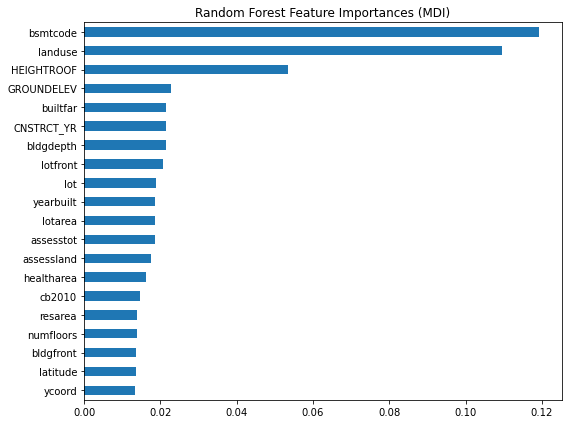

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

mdi_importances.plot.barh(ax=ax)

plt.title("Random Forest Feature Importances (MDI)")
plt.tight_layout()